# 6. Decision Trees and Ensemble Learning

This week, we'll talk about decision trees and tree-based ensemble algorithms:
- Decision trees and the decision tree learning algorithm
- Random forests: putting multiple trees together into one model
- Gradient boosting as an alternative way of combining decision trees

## 6.1 Credit risk scoring project

The project we prepared for this week is default prediction: predict whether or not a customer will fail to pay back a loan. 
* Dataset from a [Data Mining course at the Polytechnic University of Catalonia](https://www.cs.upc.edu/~belanche/Docencia/mineria/mineria.html)
  * A copy of this dataset made available on GitHub: https://github.com/gastonstat/CreditScoring
  * The dataset describes the customers (seniority, age, martial status, income, and other characteristics), the loan (the requested amount, the price of the item), and its status (paid back or not). 

Imagine that we work at a bank. When we receive a loan application, we need to make sure that if we loan the money, the customer will be able to pay it back. Every application carries a risk of *default*--the failure to return the money.

We'd like to minimize this risk: before agreeing to give a loan, we want to score the customer and assess the chances of default. If it's too high, we reject the application. This process is called "credit risk scoring."

Machine learning can be used for calculating the risk. For that, we need a dataset with loans, where for each application, we know whether or not it was paid back successfully. Using this data, we can build a model for predicting the probability of default, and we can use this model to assess the risk of future borrowers not repaying the money. 

The plan for this project is as follows:
- First, we get the data and do some initial preprocessing.
- Next, we train a decision tree model from Scikit-learn for predicting the probability of default.
- After that, we explain how decision trees work and which parameters the model has and show how to adjust these parameters to get the best performance.
- Then we combine multiple decision trees into one model--a random forest. We look at its parameters and tune them to achieve the best predictive performance.
- Finally, we explore a different way of combining decision trees--gradient boosting. We use XGBoost, a highly efficient library that implements gradient boosting. We'll train a model and tune its parameters. 

Credit risk scoring is a binary classification problem: the target is positive ("1") if the customer defaults and negative ("0") otherwise. 
$$y_i \in \{0, 1\}$$
$$g(x_i) \rightarrow \text{Probability of Default}$$

For evaluating our solution, we'll use AUC (area under the ROC curve). AUC describes how well our model can separate the cases into positive and negative ones. 

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

## 6.2 Data cleaning and preparation

In this session, we clean and prepare the dataset for the model. This involves the following steps:
* Downloading the dataset from the given link
* Re-encoding the categorical variables
  * Reformat categorical columns (`status`, `home`, `marital`, `records`, and `job`) by mapping them with appropriate values.
* Clean the data
  * Replace the maximum value of `income`, `assets`, and `debt` columns with NaNs.
  * Replace the NaNs in the dataframe with `0`.
  * Extract only those rows in the column `status` which are either `ok` or `default` as value. 
* Doing the train/validation/test split
  * Split the data using a two-step process that leads to the distribution of 60% train, 20% validation, and 20% test sets with random seed=`11`.
* Prepare the target variable
  * Prepare target variable `status` by converting it from categorical to binary, where 0 represents `ok` and 1 represents `default`.
  * Finally, delete the target variable from the train/val/test dataframe.

In [2]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv'

In [3]:
# !wget $data

In [4]:
# !head: a Linux tool to show the first 10 rows of the csv file
# !head CreditScoring.csv

In [5]:
df = pd.read_csv(data)
df

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4450,2,1,1,60,39,2,1,1,69,92,0,0,900,1020
4451,1,22,2,60,46,2,1,1,60,75,3000,600,950,1263
4452,2,0,2,24,37,2,1,2,60,90,3500,0,500,963
4453,1,0,1,48,23,1,1,3,49,140,0,0,550,550


In [6]:
df.head()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [7]:
# Lowercase the column names
df.columns = df.columns.str.lower()
df.columns

Index(['status', 'seniority', 'home', 'time', 'age', 'marital', 'records',
       'job', 'expenses', 'income', 'assets', 'debt', 'amount', 'price'],
      dtype='object')

In [8]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


We can see that the DataFrame has the following columns:
- `status`: whether the customer managed to pay back the loan (1) or not (2)
- `seniority`: job experience in years
- `home`: type of homeownership: renting (1), a homeowner (2), and others
- `time`: period planned for the loan (in months)
- `age`: age of the client
- `marital[status]`: single (1), married (2), and others
- `records`: whether the client has any previous records: no (1), yes (2) (It's not clear from the dataset description what kind of records we have in this column. For the purposes of this project, we may assume that it's about records in the bank's database.)
- `job`: type of job: full-time (1), part-time (2), and others
- `expenses`: how much the client spends per month
- `income`: how much the client earns per month
- `assets`: total worth of all the assets of the client
- `debt`: amount of credit debt
- `amount`: requested amount of the loan
- `price`: price of an item the client wants to buy

Although most of the columns are numerical, some are categorical: status, home, marital [status], records, and job. The values we see in the DataFrame, however, are numbers, not strings. This means that we need to translate them to their actual names (refer to this [R script](https://github.com/gastonstat/CreditScoring/blob/master/Part1_CredScoring_Processing.R) to help us in decoding the numbers to categories). 

In [9]:
df.status.value_counts()

status
1    3200
2    1254
0       1
Name: count, dtype: int64

In Pandas, we can use `map` for converting the numbers to strings. 

In [10]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)
df.status

0            ok
1            ok
2       default
3            ok
4            ok
         ...   
4450    default
4451         ok
4452    default
4453         ok
4454         ok
Name: status, Length: 4455, dtype: object

In [11]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,1,60,30,2,1,3,73,129,0,0,800,846
1,ok,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,default,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,ok,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,ok,0,1,36,26,1,1,1,46,107,0,0,310,910


In [12]:
home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

In [13]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


After these transformations, the columns with categorical variables contain the actual values, not numbers. 

As the next step, let's take a look at numerical columns. First, let's check the summary statistics for each of the columns.

> **Note:** To force Pandas to use a different notation, we use `round`: it removes the fractional part of a number and rounds it to the closest integer.

It gives us an idea of how the distribution of the values in each column looks. 

In [14]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


One thing we notice immediately is that the max value is 99999999 in some cases. This is quite suspicious. As it turns out, it's an artificial value--this is how missing values are encoded in this dataset. 

Three columns have this problem: `income`, `assets`, and `debt`. Let's replace this big number with `NaN` for these columns.

In [15]:
df.income.max()

np.int64(99999999)

In [16]:
df.income.replace(to_replace=99999999, value=np.nan).max()

np.float64(959.0)

In [17]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=np.nan)

In [18]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4421.0,4408.0,4437.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,131.0,5403.0,343.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,86.0,11573.0,1246.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3000.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,165.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,959.0,300000.0,30000.0,5000.0,11140.0


Before we finish with dataset preparation, let's look at our target variable `status`. 

In [19]:
df.status.value_counts()

status
ok         3200
default    1254
unk           1
Name: count, dtype: int64

Notice that there's one row with "unknown" status: we don't know whether or not this client managed to pay back the loan. For our project, this row is not useful, so let's remove it from the dataset. 

In [20]:
df = df[df.status != 'unk'].reset_index(drop=True)
df

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129.0,0.0,0.0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131.0,0.0,0.0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200.0,3000.0,0.0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182.0,2500.0,0.0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107.0,0.0,0.0,310,910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4449,default,1,rent,60,39,married,no,fixed,69,92.0,0.0,0.0,900,1020
4450,ok,22,owner,60,46,married,no,fixed,60,75.0,3000.0,600.0,950,1263
4451,default,0,owner,24,37,married,no,partime,60,90.0,3500.0,0.0,500,963
4452,ok,0,rent,48,23,single,no,freelance,49,140.0,0.0,0.0,550,550


By looking at the data, we have identified a few important issues in the data and addressed them. 

Now our dataset is cleaned, and we're almost ready to use it for model training. But before we can do that, we need to do a few more steps:
- Split the dataset into train, validation, and test.
- Handle missing values.
- Use one-hot encoding to encode categorical variables.
- Create the feature matrix $X$ and the target variable $y$.

In [21]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)

In [22]:
df_train

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
951,default,10,owner,36,36,married,no,freelance,75,0.0,10000.0,0.0,1000,1400
688,default,6,parents,48,32,single,yes,fixed,35,85.0,0.0,0.0,1100,1330
2233,ok,1,parents,48,40,married,no,fixed,75,121.0,0.0,0.0,1320,1600
3304,default,1,parents,48,23,single,no,partime,35,72.0,0.0,0.0,1078,1079
2271,ok,5,owner,36,46,married,no,freelance,60,100.0,4000.0,0.0,1100,1897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2382,ok,18,private,36,45,married,no,fixed,45,220.0,20000.0,0.0,800,1600
1784,ok,7,private,60,29,married,no,fixed,60,51.0,3500.0,500.0,1000,1290
808,ok,1,parents,24,19,single,no,fixed,35,28.0,0.0,0.0,400,600
1857,ok,15,owner,48,43,married,no,freelance,60,100.0,18000.0,0.0,2500,2976


In [23]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [24]:
df_train

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,default,10,owner,36,36,married,no,freelance,75,0.0,10000.0,0.0,1000,1400
1,default,6,parents,48,32,single,yes,fixed,35,85.0,0.0,0.0,1100,1330
2,ok,1,parents,48,40,married,no,fixed,75,121.0,0.0,0.0,1320,1600
3,default,1,parents,48,23,single,no,partime,35,72.0,0.0,0.0,1078,1079
4,ok,5,owner,36,46,married,no,freelance,60,100.0,4000.0,0.0,1100,1897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2667,ok,18,private,36,45,married,no,fixed,45,220.0,20000.0,0.0,800,1600
2668,ok,7,private,60,29,married,no,fixed,60,51.0,3500.0,500.0,1000,1290
2669,ok,1,parents,24,19,single,no,fixed,35,28.0,0.0,0.0,400,600
2670,ok,15,owner,48,43,married,no,freelance,60,100.0,18000.0,0.0,2500,2976


In [25]:
df_train.status

0       default
1       default
2            ok
3       default
4            ok
         ...   
2667         ok
2668         ok
2669         ok
2670         ok
2671         ok
Name: status, Length: 2672, dtype: object

The outcome we want to predict is `status`. We will use it to train a model, so it's our $y$--the target variable. Because our objective is to determine if somebody fails to pay back their loan, the positive class is `default`. 

This means that $y$ is "1" if the client defaulted and "0" otherwise. 

In [26]:
y_train = (df_train.status == 'default').astype('int').values
y_val = (df_val.status == 'default').astype('int').values
y_test = (df_test.status == 'default').astype('int').values

In [27]:
y_train

array([1, 1, 0, ..., 0, 0, 0])

We need to remove `status` from the DataFrames. If we don't, we may accidentally use this variable for training. 

In [28]:
del df_train['status']
del df_val['status']
del df_test['status']

In [29]:
df_train.head().T

,0,1,2,3,4
seniority,10,6,1,1,5
home,owner,parents,parents,parents,owner
time,36,48,48,48,36
age,36,32,40,23,46
marital,married,single,married,single,married
records,no,yes,no,no,no
job,freelance,fixed,fixed,partime,freelance
expenses,75,35,75,35,60
income,0.0,85.0,121.0,72.0,100.0
assets,10000.0,0.0,0.0,0.0,4000.0


## 6.3 Decision trees
* How a decision tree looks like
* Training a decision tree 
* Overfitting
* Controlling the size of a tree

Decision Trees are powerful algorithms, capable of fitting complex datasets. A decision tree is a data structure that encodes a series of *if-then-else* rules. Each node in a tree contains a condition. If the condition is satisfied, we go to the right side of the tree; otherwise, we go to the left. In the end, we arrive at the final decision. 

Though versatile, the decision tree is also prone to overfitting. One of the reasons why this algorithm often overfits is its depth. It tends to memorize all the patterns in the train data but struggles to perform well on the unseen data (validation or test set). 

To overcome the overfitting problem, we can reduce the complexity of the algorithm by reducing the depth size. 

A decision tree with a depth of 1 is called `decision stump`. It has only one split from the root.

**Classes, functions, and methods:**
- `DecisionTreeClassifier`: classification model from `sklearn.tree` class.
- `max_depth`: hyperparameter to control the maximum depth of decision tree algorithm.
- `export_text`: method from `sklearn.tree` class to display the text report showing the rules of a decision tree.

*NOTE: We have already covered `DictVectorizer` in session 3 and `roc_auc_score` in session 4 respectively.* 

In [30]:
# Represent a decision tree as a set of if-else statements in Python
def assess_risk(client):
    if client['records'] == 'yes':
        if client['job'] == 'parttime':
            return 'default'
        else:
            return 'ok'
    else:
        if client['assets'] > 6000:
            return 'ok'
        else:
            return 'default'

In [31]:
# Retrieve the first record
xi = df_train.iloc[0].to_dict()
xi

{'seniority': 10,
 'home': 'owner',
 'time': 36,
 'age': 36,
 'marital': 'married',
 'records': 'no',
 'job': 'freelance',
 'expenses': 75,
 'income': 0.0,
 'assets': 10000.0,
 'debt': 0.0,
 'amount': 1000,
 'price': 1400}

In [32]:
# Apply assess_risk function to this client
assess_risk(xi)

'ok'

The decision we've just created predicted that this customer is going to be fine. The customer didn't have any records and have 10,000 in assets. That is how we arrive at this final decision. 

With machine learning, we can extract these rules from data automatically. 

We'll use Scikit-learn for training a decision tree. Because we're solving a classification problem, we need to use `DecisionTreeClassifier` from the `tree` package. 

In [33]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text

In [34]:
# Replace the missing values with zero and convert the DataFrame into a list of dictionaries
train_dicts = df_train.fillna(0).to_dict(orient='records')

In [35]:
train_dicts[:3]

[{'seniority': 10,
  'home': 'owner',
  'time': 36,
  'age': 36,
  'marital': 'married',
  'records': 'no',
  'job': 'freelance',
  'expenses': 75,
  'income': 0.0,
  'assets': 10000.0,
  'debt': 0.0,
  'amount': 1000,
  'price': 1400},
 {'seniority': 6,
  'home': 'parents',
  'time': 48,
  'age': 32,
  'marital': 'single',
  'records': 'yes',
  'job': 'fixed',
  'expenses': 35,
  'income': 85.0,
  'assets': 0.0,
  'debt': 0.0,
  'amount': 1100,
  'price': 1330},
 {'seniority': 1,
  'home': 'parents',
  'time': 48,
  'age': 40,
  'marital': 'married',
  'records': 'no',
  'job': 'fixed',
  'expenses': 75,
  'income': 121.0,
  'assets': 0.0,
  'debt': 0.0,
  'amount': 1320,
  'price': 1600}]

In [36]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [37]:
X_train

array([[3.60e+01, 1.00e+03, 1.00e+04, ..., 0.00e+00, 1.00e+01, 3.60e+01],
       [3.20e+01, 1.10e+03, 0.00e+00, ..., 1.00e+00, 6.00e+00, 4.80e+01],
       [4.00e+01, 1.32e+03, 0.00e+00, ..., 0.00e+00, 1.00e+00, 4.80e+01],
       ...,
       [1.90e+01, 4.00e+02, 0.00e+00, ..., 0.00e+00, 1.00e+00, 2.40e+01],
       [4.30e+01, 2.50e+03, 1.80e+04, ..., 0.00e+00, 1.50e+01, 4.80e+01],
       [2.70e+01, 4.50e+02, 5.00e+03, ..., 1.00e+00, 1.20e+01, 4.80e+01]])

In [38]:
dv.get_feature_names_out()

array(['age', 'amount', 'assets', 'debt', 'expenses', 'home=ignore',
       'home=other', 'home=owner', 'home=parents', 'home=private',
       'home=rent', 'home=unk', 'income', 'job=fixed', 'job=freelance',
       'job=others', 'job=partime', 'job=unk', 'marital=divorced',
       'marital=married', 'marital=separated', 'marital=single',
       'marital=unk', 'marital=widow', 'price', 'records=no',
       'records=yes', 'seniority', 'time'], dtype=object)

In [39]:
dt = DecisionTreeClassifier()
# Train the model
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [40]:
val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)

To check if the result is good, we need to evaluate the predictive performance of the model on the validation set. Let's use AUC (area under the ROC curve) for that. 

Credit risk scoring is a binary classification problem, and for cases like that, AUC is one of the best evaluation metrics. AUC shows how well a model separates positive examples from negative examples. It describes the probability that a randomly chosen positive example ("default") has a higher score than a randomly chosen negative example ("OK"). This is a relevant metric for the project: we want risky clients to have higher scores than non-risky ones. 

Because we chose AUC as the evaluation metric, we need scores, not hard predictions. 

In [41]:
# Evaluate the performance on the training set
y_pred = dt.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)

np.float64(1.0)

We see that the score is 100% (perfect score). Does it mean we can predict default without errors? 

Let's check the score on validation before jumping to conclusions. 

In [42]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

np.float64(0.6580247511564263)

We see that the AUC on validation is only about 66%. This is a case of overfitting: the tree learned the training data so well that it simply memorized the outcome for each customer. However, when we applied it to the validation set, the model failed.  

Overfitting is when our model simply memorizes the data but memorizes it in such a way when it sees a new example, it is clueless on what to do with this example because it doesn't look like any of the memorized data points. So it memorizes the data but fails to generalize because for new unseen examples, none of the memorized examples look like this new one and so, the model just outputs something completely incorrect. 

The rules it extracted from the data turned out to be too specific to the training set, so it worked poorly for customers it didn't see during training. 

In [43]:
xi

{'seniority': 10,
 'home': 'owner',
 'time': 36,
 'age': 36,
 'marital': 'married',
 'records': 'no',
 'job': 'freelance',
 'expenses': 75,
 'income': 0.0,
 'assets': 10000.0,
 'debt': 0.0,
 'amount': 1000,
 'price': 1400}

In [44]:
y_train[0]

np.int64(1)

Overfitting happens when we have a complex model with enough power to remember all the training data. If we force the model to be simpler, we can make it less powerful and improve the model's ability to generalize. 

We have multiple options to control the complexity of a tree. One option is to restrict its size: we can specify the `max_depth` parameter, which controls the maximum number of levels. The more the levels a tree has, the more complex rules it can learn. 

The default value for `max_depth` is `None`, which means that the tree can grow as large as possible. We can try a smaller value and compare the results. 

In [45]:
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

In [46]:
y_pred = dt.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred)
print('train:', auc)

y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print('val:', auc)

train: 0.7761016984958594
val: 0.7389079944782155


We can see that the performance of our model on validation (with `max_depth` = 3) is significantly better. So, it's about 74% compared to about 66% (with `max_depth` = None), which is 8% better. 

Let's try setting the `max_depth` to 1.

In [47]:
dt = DecisionTreeClassifier(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=1)

In [48]:
y_pred = dt.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred)
print('train:', auc)

y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print('val:', auc)

train: 0.6282660131823559
val: 0.6058644740984719


The model with only one condition performs worse than what we have previously. 

This kind of tree is called a **Decision Stump**. Notice that the performance of this decision stump (61%) is only slightly worse than the overfitted one (66%). 

Let's take a look at what kind of rules the tree has learned during training.

To visualize the tree we just learned, we can use `export_text` function from the `tree` package. 

In [49]:
print(export_text(dt))

|--- feature_25 <= 0.50
|   |--- class: 1
|--- feature_25 >  0.50
|   |--- class: 0



In [50]:
# Label the feature using the feature_names param
print(export_text(dt, feature_names=dv.get_feature_names_out()))

|--- records=no <= 0.50
|   |--- class: 1
|--- records=no >  0.50
|   |--- class: 0



In [51]:
# A decision tree with two levels
dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2)

In [52]:
y_pred = dt.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred)
print('train:', auc)

y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print('val:', auc)

train: 0.7054989859726213
val: 0.6685264343319367


It turns out that the AUC of this simple decision tree with just two levels (67%) is actually better than a decision tree that will grow indefinitely with many layers (66%). 

In [53]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- records=no <= 0.50
|   |--- seniority <= 6.50
|   |   |--- class: 1
|   |--- seniority >  6.50
|   |   |--- class: 0
|--- records=no >  0.50
|   |--- job=partime <= 0.50
|   |   |--- class: 0
|   |--- job=partime >  0.50
|   |   |--- class: 1



We see that by making the tree less complex, we improved the ability of our model to generalize, thus better at predicting the outcomes for customers it hasn't seen previously. 

However, this tree has another problem--it's too simple. To make it better, we need to tune the model: try different parameters, and see which ones lead to the best AUC. In addition to `max_depth`, we can control other parameters. To understand what these parameters mean and how they influence the model, let's take a step back and look at how decision trees learn rules from data. 

## 6.4 Decision tree learning algorithm
In this session, we will learn about how to best split a decision tree and the different classification criteria that can be used to split a tree. We dive deep into an example, splitting trees with `misclassification` criteria. Additionally, we discuss the different stopping criteria to break the iterative tree split. 
* Finding the best split for one column
* Finding the best split for the entire dataset
* Stopping criteria
* Decision tree learning algorithm

**Structure of a decision tree:** 
- A decision tree is a data structure composed of **nodes** (which contain conditions) and **branches** (which represent the values for a condition: True or False). The tree starts with a **root node**, which is the parent of two other nodes, and each of these nodes can also be the parent of others. At the last level of the tree, there are terminal nodes, also called **leaves**. 

**Depth of a decision tree:** 
- The **depth** of a tree is the number of levels it has, or simply, the length of the longest path from the root node to a leaf node. 

**Rules, Conditions, Thresholds:** 
- The learning algorithm for a decision tree involves determining the best **conditions** to split the data at each node in order to achieve the best possible classifier. When there are many **features**, the algorithm considers each feature with its optimized **threshold** to determine the best feature for splitting at a particular node. In essence, at each node, the algorithm evaluates all possible thresholds for every feature and calculates the resulting misclassification rate. It then selects the condition (feature and threshold) that yields the lowest impurity. 

**Misclassification rate:** 
- After each split, the goal is to divide the data into two sets that are as **pure** as possible. This means that the data within each set should belong predominantly to either one class, or the other. Another way to describe this is to aim for the lowest possible **misclassification rate** (impurity). The misclassification rate is a weighted average of the error rates obtained after splitting the data into two sets. The predicted class for each set is determined by the **majority class** present in this set.

**Impurity criteria:**
- Common misclassification rate measurements are **GINI Impurity** and **Entropy**. It is also possible to use **MSE** for regression problems.

**Decision trees can be used to solve regression problems:** 
- While we focused on decision tree classifiers, it's important to note that decision trees can also be applied to regression problems using decision tree regressors.

**Stopping Criteria:**
- The process of recursively splitting the data at each child node eventually stops based on certain **stopping criteria**. These criteria prevent the model from overfitting and include:
  - The group is already **pure**: 0% impurity.
  - The **maximum depth** has been reached.
  - The group is **smaller** than the minimum size set for groups.
  - The maximum number of **leaves/terminal nodes** has been reached.

#### Decision Tree Learning Algorithm in a Nutshell
* At a node, find the best split.
* Stop if max_depth is reached.
* For each child node, if the node is sufficiently large and not pure, repeat the process from the beginning. 

To understand how a decision tree learns from data, we'll first use a much smaller dataset with just one feature: `assets`. 

Second, we'll grow a very small tree, with just a single node. The only feature we have in the dataset is `assets`. This is why the condition in the node will be `assets > T`, where T is a threshold value that we need to determine. If the condition is true, we'll predict "OK", and if it's false, our prediction will be "default".

The condition `assets > T` is called a *split*. It splits the dataset into two groups: the data points that satisfy the condition (on the right) and the data points that do not (on the left). Here, we're interested in "What's the best $T$?" 

In [54]:
data = [
    [8000, 'default'],
    [2000, 'default'],
    [   0, 'default'],
    [5000, 'ok'],
    [5000, 'ok'],
    [4000, 'ok'],
    [9000, 'ok'],
    [3000, 'default'],
]

df_example = pd.DataFrame(data, columns=['assets', 'status'])
df_example

,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


In [55]:
df_example.sort_values('assets')

,assets,status
2,0,default
1,2000,default
7,3000,default
5,4000,ok
4,5000,ok
3,5000,ok
0,8000,default
6,9000,ok


In [56]:
from IPython.display import display

In [57]:
T = 4000
df_left = df_example[df_example.assets <= T]
df_right = df_example[df_example.assets > T]

display(df_left)
print(df_left.status.value_counts(normalize=True))
display(df_right)
print(df_right.status.value_counts(normalize=True))

,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


status
default    0.75
ok         0.25
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


status
ok         0.75
default    0.25
Name: proportion, dtype: float64


Now, we turn these groups into leaves--the decision nodes--by taking the most frequent status in each group and using it as the final decision. In our example, "DEFAULT" is the most frequent outcome in the left group and "OK" is the most frequent outcome in the right group.

Thus, if a customer has more than $4,000 in assets, our decision is "OK". Otherwise, it's "DEFAULT". 

These groups should be as homogeneous as possible. Ideally, each group should contain only observations of one class. In thiscase, we call these groups *pure*.

For example, if we have a group of four customers with outcomes ["DEFAULT", "DEFAULT", "DEFAULT", "DEFAULT"], it's pure: contains only customers who defaulted. But a group ["DEFAULT", "DEFAULT", "DEFAULT", "OK"] is impure: there's one customer who didn't default. 

When training a decision tree model, we want to find such $T$ that the *impurity* of both groups is minimal. The algorithm for finding $T$ is quite simple:
- Try all possible values of $T$.
- For each $T$, split the dataset into left and right groups and measure their impurity.
- Select $T$ that has the lowest degree of impurity.

We can use different criteria for measuring *impurity*. The easiest one to understand is the **misclassification rate**, which says how many observations in a group don't belong to the majority class. 
> **NOTE:** Scikit-learn uses more advanced split criteria such as entropy and the Gini impurity. They measure the degree of impurity of the split.


Let's calculate the misclassification rate for the split, $T = 4000$:
- For the left group, the majority class is "DEFAULT". There are four data points in total, and one doesn't belong to "DEFAULT". The misclassification rate is 25% (1/4).
- For the right group, "OK" is the majority class, and there's one "DEFAULT". Thus, the misclassification rate is also 25% (1/4).
- To calculate the overall impurity of the split, we can take the average across both groups. In this case, the average is 25%.

> **NOTE:** In reality, instead of taking the simple average across both groups, we take a weighted average--we weight each group proportionally to its size. To simplify calculations, we use the simple average. 

In [58]:
Ts = [0, 2000, 3000, 4000, 5000, 8000]

In [59]:
# Try other values for T
for T in Ts:
    print(T)
    df_left = df_example[df_example.assets <= T]
    df_right = df_example[df_example.assets > T]
    
    display(df_left)
    print(df_left.status.value_counts(normalize=True))
    display(df_right)
    print(df_right.status.value_counts(normalize=True))

    print()

0


,assets,status
2,0,default


status
default    1.0
Name: proportion, dtype: float64


,assets,status
0,8000,default
1,2000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64

2000


,assets,status
1,2000,default
2,0,default


status
default    1.0
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64

3000


,assets,status
1,2000,default
2,0,default
7,3000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok


status
ok         0.8
default    0.2
Name: proportion, dtype: float64

4000


,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


status
default    0.75
ok         0.25
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


status
ok         0.75
default    0.25
Name: proportion, dtype: float64

5000


,assets,status
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


status
default    0.5
ok         0.5
Name: proportion, dtype: float64


,assets,status
0,8000,default
6,9000,ok


status
default    0.5
ok         0.5
Name: proportion, dtype: float64

8000


,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64


,assets,status
6,9000,ok


status
ok    1.0
Name: proportion, dtype: float64



**Assets:** 
| T | Decision (Left)  | Impurity (Left) | Decision (Right) | Impurity (Right) | AVG |
| -: | :-: | :-: | :-: | :-: | :-: |
| 0 | DEFAULT | 0% | OK | 43% | 21% |
| 2000 | DEFAULT | 0% | OK | 33% | 16% |
| 3000 | DEFAULT | 0% | OK | 20% | 10% |
| 4000 | DEFAULT | 25% | OK | 25% | 25% |
| 5000 | DEFAULT | 50% | OK | 50% | 50% |
| 8000 | DEFAULT | 43% | OK | 0% | 21% |

Best $T$ = 3000, Impurity: 10% 
- We see that the best average impurity is 10% for $T$ = 3000: we got zero mistakes for the left tree and only one (out of five rows) for the right. So, we should select 3000 as the threshold for our final model.

This is how we find the best split if we just have one feature. Now, let's make the problem a bit more complex and add another feature to the dataset: `debt`

Previously, we had only one feature: `assets`. We knew for sure that it would be used for splitting the data. Now, we have two features, so in addition to selecting the best threshold for splitting, we need to figure out which feature to use.

The solution is simple: we try all the features, and for each feature, select the best threshold. 

Let's modify the training algorithm to include this change: 
- For each feature, try all possible thresholds.
- For each threshold value $T$, measure the impurity of the split.
- Select the feature and the threshold with the lowest impurity possible.


In [60]:
data = [
    [8000, 3000, 'default'],
    [2000, 1000, 'default'],
    [   0, 1000, 'default'],
    [5000, 1000, 'ok'],
    [5000, 1000, 'ok'],
    [4000, 1000, 'ok'],
    [9000,  500, 'ok'],
    [3000, 2000, 'default'],
]

df_example = pd.DataFrame(data, columns=['assets', 'debt', 'status'])
df_example

,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


In [61]:
df_example.sort_values('debt')

,assets,debt,status
6,9000,500,ok
1,2000,1000,default
3,5000,1000,ok
2,0,1000,default
5,4000,1000,ok
4,5000,1000,ok
7,3000,2000,default
0,8000,3000,default


We see that the possible thresholds are `500`, `1000`, `2000` for `debt`. 

In [62]:
thresholds = {
    'assets': [0, 2000, 3000, 4000, 5000, 8000],
    'debt': [500, 1000, 2000]
}

In [63]:
for feature, Ts in thresholds.items():
    print('#####################')
    print(feature)
    for T in Ts:
        print(T)
        df_left = df_example[df_example[feature] <= T]
        df_right = df_example[df_example[feature] > T]

        display(df_left)
        print(df_left.status.value_counts(normalize=True))
        display(df_right)
        print(df_right.status.value_counts(normalize=True))

        print()
    print('#####################')

#####################
assets
0


,assets,debt,status
2,0,1000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64

2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64

3000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
7,3000,2000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


status
ok         0.8
default    0.2
Name: proportion, dtype: float64

4000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
5,4000,1000,ok
7,3000,2000,default


status
default    0.75
ok         0.25
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
6,9000,500,ok


status
ok         0.75
default    0.25
Name: proportion, dtype: float64

5000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.5
ok         0.5
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
6,9000,500,ok


status
default    0.5
ok         0.5
Name: proportion, dtype: float64

8000


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64


,assets,debt,status
6,9000,500,ok


status
ok    1.0
Name: proportion, dtype: float64

#####################
#####################
debt
500


,assets,debt,status
6,9000,500,ok


status
ok    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64

1000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
7,3000,2000,default


status
default    1.0
Name: proportion, dtype: float64

2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default


status
default    1.0
Name: proportion, dtype: float64

#####################


Let's apply this algorithm to our dataset:
- We already identified that for `assets`, the best $T$ is 3000. The average impurity of this split is 10%.
- For `debt`, the best $T$ is 1000. In this case, the average impurity is 17%.

**Assets:** 
| T | Decision (Left)  | Impurity (Left) | Decision (Right) | Impurity (Right) | AVG |
| -: | :-: | :-: | :-: | :-: | :-: |
| 0 | DEFAULT | 0% | OK | 43% | 21% |
| 2000 | DEFAULT | 0% | OK | 33% | 16% |
| 3000 | DEFAULT | 0% | OK | 20% | 10% |
| 4000 | DEFAULT | 25% | OK | 25% | 25% |
| 5000 | DEFAULT | 50% | OK | 50% | 50% |
| 8000 | DEFAULT | 43% | OK | 0% | 21% |

**Debt:** 
| T | Decision (Left)  | Impurity (Left) | Decision (Right) | Impurity (Right) | AVG |
| -: | :-: | :-: | :-: | :-: | :-: |
| 500 | OK | 0% | DEFAULT | 43% | 21% |
| 1000 | OK | 33% | DEFAULT | 0% | 16% |
| 2000 | OK | 43% | DEFAULT | 0% | 21% |

We see that `debt` is not as useful as `assets` for splitting the data. So, the best split is `assets > 3000`. 

#### Finding the best split algorithm:
```
For f in features:
    Find all thresholds for f
    For t in thresholds:
        Split dataset using "F > T" condition
        Compute the impurity of this split
Select the condition with the lowest impurity
```

Using `assets > 3000` split as example, the group on the left is already pure, but the group on the right is not. We can make it less impure by repeating the process: split it again!

When we apply the same algorithm to the dataset on the right, we find that the best split condition is `debt > 1000`. We have two levels in the tree now--or we can say that the depth of this tree is 2. 

Before the decision tree is ready, we need to do the last step: convert the groups into decision nodes. For that, we take the most frequent status in each group. This way, we get a decision tree. 

#### Stopping Criteria
When training a decision tree, we can keep splitting the data until all the groups are pure. This is exactly what happens when we don't put any restrictions on the trees in Scikit-learn. As we've seen, the resulting model becomes too complex, which leads to overfitting. 

We solved this problem by using the `max_depth` parameter--we restricted the tree size and didn't let it grow too big. 

To decide if we want to continue splitting the data, we use *stopping criteria*--criteria that describe if we should add another split in the tree or stop. The most common stopping criteria are:
- The group is already pure.
- The tree reached the depth limit (controlled by the `max_depth` parameter).
- The group is too small to continue splitting (controlled by the `min_samples_leaf` parameter).

By using these criteria to stop earlier, we force our model to be less complex and therefore, reduce the risk of overfitting. 

Let's use this information to adjust the training algorithm:
- Find the best split:
  - For each feature, try all possible threshold values.
  - Use the one with the lowest impurity.
- If the maximum allowed depth (`max_depth`) is reached, stop.
- If the group on the left is sufficiently large and it's not pure yet, repeat on the left.
- If the group on the right is sufficiently large and it's not pure yet, repeat on the right.

> **NOTE<sup>1</sup>:** We're using "Misclassification rate" as a measure of impurity in this project.
> $$H(Q_m) = 1 - max(p_{mk})$$
> The other common measures of impurity are "Gini" and "Entropy".
> 
> In practice, we don't really use misclassification rate.
> 
> Refer to https://scikit-learn.org/1.5/modules/tree.html#classification-criteria for more details on the different classification criteria.

> **NOTE<sup>2</sup>:** Decision trees can also be used for solving regression problems. The kind of impurity criteria you can use for solving regression problems are Mean Squared Error (MSE or L2 error), Poisson deviance, and Mean Absolute Error (MAE or L1 error).

Even though this is a simplified version of the decision tree learning algorithm, it should provide you enough intuition about the internals of the learning process. 

Most importantly, we know two parameters (`max_depth` and `min_samples_leaf`) control the complexity of the model. By changing these parameters, we can improve the performance of the model. 

## 6.5 Decision trees parameter tuning
The process of finding the best set of parameters is called **parameter tuning**. We usually do it by changing the model and checking its score on the validation dataset. In the end, we use the model with the best validation score. 

As we have just learned, we can tune two parameters:
* `max_depth`
* `min_samples_leaf`

#### Steps
- **Fine-tuning Process:** iterate to find the optimal parameter settings.
  - Start by tuning `max_depth` with various values to determine a subset of optimal depths.
  - Then, using this subset, fine-tune the model further by exploring different `min_samples_leaf` values.

  This method is computationally efficient for **large datasets**, though it may not be optimal for smaller ones.
- **Heatmaps for Visualization:** Store the scores (e.g., AUC) obtained during tuning in a pivot table, and create a heatmap with `seaborn` to easily identify high score areas, which helps pinpoint the optimal `max_depth` and `min_samples_leaf` combination.

**NB:** Choose parameter values that effectively control the tree's size and avoid values like `nan` (Not a Number), even if they seem to lead to better scores. 

#### Importance of `max_depth` and `min_samples_leaf`
These two are the most important ones, so we will adjust only them. You can check the other parameters in the official documentation (https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html). 
- **Controlling Overfitting:** The following parameters play a critical role in preventing overfitting.
  - `max_depth`: limits the tree's complexity, preventing it from growing too deep and memorizing the training data.
  - `min_samples_leaf`: ensures that leaf nodes have a sufficient number of samples, reducing the chance of creating nodes that are too specific to the training data.
- **Impact on Bias and Variance:** They also affect the model's bias and variance.
  - Increasing `max_depth` and decreasing `min_samples_leaf` can lead to a more complex model with lower bias but higher variance.
  - Decreasing `max_depth` and increasing `min_samples_leaf` results in a simpler model with higher bias but lower variance.

It's then important to find the right balance between `max_depth` and `min_samples_leaf` to achieve optimal model performance. This involves a trade-off between bias and variance, and the best values depend on the specific dataset and problem. 

In [64]:
# Shift + Tab to show documentation for in-built functions in Jupyter Notebook
DecisionTreeClassifier()

DecisionTreeClassifier()

Let's find the best parameters. We start by tuning `max_depth`. For that, we iterate over a few reasonable values and see what works best. 

The value `None` means that there's no restriction on depth, so the tree will grow as large as it can. 

In [65]:
depths = [1, 2, 3, 4, 5, 6, 10, 15, 20, None]

for depth in depths: 
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(X_train, y_train)
    
    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    print('%4s -> %.3f' % (depth, auc))

   1 -> 0.606
   2 -> 0.669
   3 -> 0.739
   4 -> 0.761
   5 -> 0.767
   6 -> 0.760
  10 -> 0.697
  15 -> 0.654
  20 -> 0.648
None -> 0.661


We see that the `max_depth` within the range of [4, 5, 6] produces the optimal values. 

If that was the only parameter for the tree, we would go with 4. But this is not the only parameter, we also talked about the other parameter `min_samples_leaf`. 

So now we get an idea that the best depth is somewhere within the range of [4, 5, 6], we will tune `min_samples_leaf`. For that, we iterate over the three best parameters of `max_depth` and for each of these depth values, we can try different `min_samples_leaf` values and see what happens. 

In [66]:
scores = []

for depth in [4, 5, 6]:
    for s in [1, 2, 5, 10, 15, 20, 100, 200, 500]:
        dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        
        scores.append((depth, s, auc))

In [67]:
scores

[(4, 1, np.float64(0.7612827250490422)),
 (4, 2, np.float64(0.7612827250490422)),
 (4, 5, np.float64(0.7612827250490422)),
 (4, 10, np.float64(0.7612827250490422)),
 (4, 15, np.float64(0.7637257513743916)),
 (4, 20, np.float64(0.760910367876777)),
 (4, 100, np.float64(0.7559365236976581)),
 (4, 200, np.float64(0.7472602988544719)),
 (4, 500, np.float64(0.679842459615897)),
 (5, 1, np.float64(0.7669377103969388)),
 (5, 2, np.float64(0.7664957254607541)),
 (5, 5, np.float64(0.7677550797994721)),
 (5, 10, np.float64(0.7622756775084158)),
 (5, 15, np.float64(0.7724050035116611)),
 (5, 20, np.float64(0.7740276331403937)),
 (5, 100, np.float64(0.7633836671429609)),
 (5, 200, np.float64(0.7590728003681189)),
 (5, 500, np.float64(0.679842459615897)),
 (6, 1, np.float64(0.757780145794483)),
 (6, 2, np.float64(0.7658327480564773)),
 (6, 5, np.float64(0.7623301688019181)),
 (6, 10, np.float64(0.7782991450921508)),
 (6, 15, np.float64(0.7852498123077667)),
 (6, 20, np.float64(0.7739822237291418)),

In [68]:
# Put the scores into a DataFrame
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores

,max_depth,min_samples_leaf,auc
0,4,1,0.761283
1,4,2,0.761283
2,4,5,0.761283
3,4,10,0.761283
4,4,15,0.763726
5,4,20,0.760910
6,4,100,0.755937
7,4,200,0.747260
8,4,500,0.679842
9,5,1,0.766938


In [69]:
df_scores.sort_values(by='auc', ascending=False).head()

,max_depth,min_samples_leaf,auc
22,6,15,0.785250
21,6,10,0.778299
24,6,100,0.776434
14,5,20,0.774028
23,6,20,0.773982


We see that the depth of 6 seems to be the best one (about 78.5% AUC) when we put a limit on the size of the leaf. 

> **NOTE:** As we can see, the value we use for `min_leaf_size` influences the best value of `max_depth`. You can experiment with a wider range of values for `max_depth` to tweak the performance further.


Let's turn this DataFrame into a "pivot" table based on its column values using the `pivot(column, row, cell)` function.

In [70]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])
df_scores_pivot.round(3)

auc              
max_depth             4      5      6
min_samples_leaf                     
1                 0.761  0.767  0.758
2                 0.761  0.766  0.766
5                 0.761  0.768  0.762
10                0.761  0.762  0.778
15                0.764  0.772  0.785
20                0.761  0.774  0.774
100               0.756  0.763  0.776
200               0.747  0.759  0.768
500               0.680  0.680  0.680

With the pivot table, it's easier to find the best parameters with the highest AUC. 

We can also visualize it using a heat map from seaborn. 

<Axes: xlabel='None-max_depth', ylabel='min_samples_leaf'>

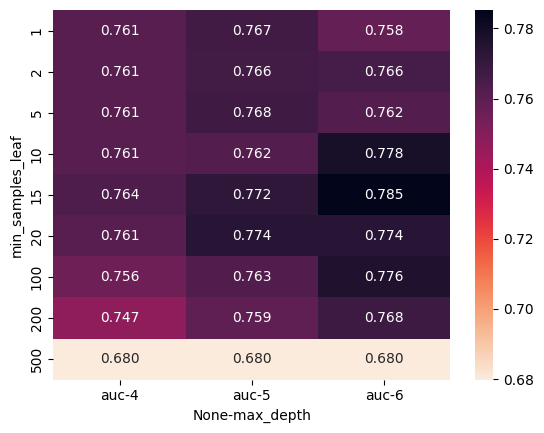

In [71]:
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f", cmap="rocket_r")

For this particular dataset, it makes sense to try more values for `max_depth` but if a dataset is big, then we cannot try every possible combination. We need to somehow restrict our search space when we are looking for the best parameters. That's why it usually makes sense first to tune the `max_depth` parameter, and then after that, tune the `min_samples_leaf` parameter. 

We can actually experiment here because this is a pretty small dataset, which enables the model to train fast.

In [72]:
scores = []

for depth in [4, 5, 6, 7, 10, 15, 20, None]:
    for s in [1, 2, 5, 10, 15, 20, 100, 200, 500]:
        dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        
        scores.append((depth, s, auc))

In [73]:
# Put the scores into a DataFrame
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

In [74]:
df_scores.sort_values(by='auc', ascending=False).head()

,max_depth,min_samples_leaf,auc
40,10.0,15,0.790193
58,20.0,15,0.787463
67,NaN,15,0.787245
49,15.0,15,0.785419
22,6.0,15,0.785250


We can see that `max_depth` of 10 and `min_samples_leaf` of 15 gives the best performance. And the second best is when we don't restrict the depth of the tree but restrict the size of the leaf. 

We get slightly better performance (79.2% AUC compared to 78.5% AUC) but it's worth keeping in mind that it can be difficult to try every possible combination. Here, we have tried only two parameters but there are actually more parameters and that's why we first look for the best depth, and then look for the best minimum sample leaves. 

In [75]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])
df_scores_pivot.round(3)

auc                                                 
max_depth           NaN   4.0    5.0    6.0    7.0    10.0   15.0   20.0
min_samples_leaf                                                        
1                 0.661  0.761  0.766  0.757  0.751  0.686  0.654  0.666
2                 0.687  0.761  0.767  0.758  0.759  0.693  0.682  0.696
5                 0.718  0.761  0.768  0.762  0.758  0.732  0.716  0.716
10                0.767  0.761  0.762  0.778  0.763  0.766  0.763  0.762
15                0.787  0.764  0.772  0.785  0.780  0.790  0.785  0.787
20                0.782  0.761  0.774  0.773  0.781  0.785  0.783  0.782
100               0.780  0.756  0.763  0.776  0.780  0.779  0.779  0.779
200               0.768  0.747  0.759  0.768  0.768  0.768  0.768  0.768
500               0.680  0.680  0.680  0.680  0.680  0.680  0.680  0.680

<Axes: xlabel='None-max_depth', ylabel='min_samples_leaf'>

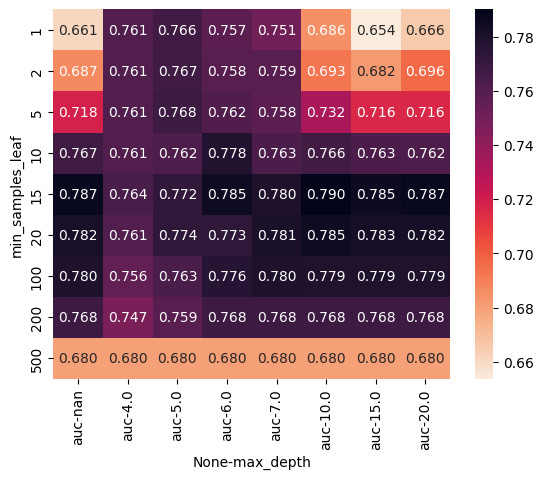

In [76]:
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f", cmap="rocket_r")

We can choose whichever we want that performed relatively well. In this case, we would still go with the one with `max_depth` of 6 and `min_samples_leaf` of 15 because it's a relatively small tree and the performance between them is not significantly different. But it's ultimately up to you, `max_depth` of 10 and `min_samples_leaf` of 15 is also fine. 

However, we wouldn't go with `max_depth` of None because it can be a bit dangerous when you don't control the size of the tree at all. It can just grow too big. So this is how we tune the parameters for decision tree. 

Let's use the best parameters we found earlier to train the final model. 

In [77]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)

In [78]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- records=yes <= 0.50
|   |--- job=partime <= 0.50
|   |   |--- income <= 74.50
|   |   |   |--- assets <= 4250.00
|   |   |   |   |--- income <= 20.00
|   |   |   |   |   |--- seniority <= 1.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- seniority >  1.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- income >  20.00
|   |   |   |   |   |--- expenses <= 71.00
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- expenses >  71.00
|   |   |   |   |   |   |--- class: 1
|   |   |   |--- assets >  4250.00
|   |   |   |   |--- debt <= 1600.00
|   |   |   |   |   |--- seniority <= 2.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- seniority >  2.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- debt >  1600.00
|   |   |   |   |   |--- class: 1
|   |   |--- income >  74.50
|   |   |   |--- seniority <= 5.50
|   |   |   |   |--- amount <= 1330.00
|   |   |   |   |   |--- assets <= 3326.00
|   |   |   |   |   |   |--- clas

Decision trees are simple and effective models, but they become even more powerful when we combine many trees together. We'll see how we can do it to achieve even better predictive performance. 

## 6.6 Ensembles and random forest
* Board of experts
* Ensembling models 
* Random forest - ensembling decision trees
* Tuning random forest

**Ensemble learning** is a machine learning paradigm where multiple models, often referred to as 'weak learners', are strategically combined to solve a particular computational intelligence problem. This approach frequently yields superior predictive performance compared to using a single model. 

**Random Forest** is an example of ensemble learning where each model is a decision tree and their predictions are aggregated to identify the most popular result. Random forest only selects a random subset of features from the original data to make predictions. The 'randomness' in Random Forest stems from two key aspects:
- Each tree is potentially trained on a bootstrapped sample of the original data, introducing randomness at the row level.
- At each node during tree construction, only a random subset of features is considered for splitting. This feature randomness helps decorrelate the trees, preventing overfitting and promoting generalization to unseen data.

**Bootstrapping** is a resampling technique where numerous subsets of the data are created by sampling the original data with replacement. This means that some data points may appear multiple times in a single bootstrap sample, while others may be excluded. In Random Forest, each decision tree is trained on a distinct bootstrap sample, further contributing to the diversity and robustness of the ensemble. 

**Parameter tuning** is crucial for optimizing the performance of a Random Forest model. Two critical parameters are `max_depth`, which controls the maximum depth of each decision tree, and `n_estimators`, which determines the number of trees in the forest. Increasing `max_depth` allows for more complex trees, potentially leading to overfitting. Conversely, a larger `n_estimators` generally improves model accuracy but increases computational cost. 

For a moment, let's suppose that we don't have a machine learning algorithm to help us with credit risk scoring. Instead, we have a group of experts.

Each expert can independently decide if we should approve a loan application or reject it. An individual expert may make a mistake. However, it's less likely that all the experts together decide to accept the application, but the customer fails to pay the money back.

Thus, we can ask all the experts independently and then combine their verdicts into the final decision, for example, by using the majority vote. 

This idea also applies to machine learning. One model individually may be wrong, but if we combine the output of multiple models into one, the chance of an incorrect answer is smaller. This concept is called *ensemble learning*, and a combination of models is called an *ensemble*. 

For this to work, the models need to be different. If we train the same decision tree model 10 times, they will all predict the same output, so it's not useful at all. 

The easiest way to have different models is to train each tree on a different subset of features. For example, suppose we have three features: `assets`, `debt`, and `price`. We can train three models:
- The first will use `assets` and `debt`.
- The second will use `debt` and `price`.
- The last one will use `assets` and `price`.

With this approach, we'll have different trees, each making its own decisions. But when we put their predictions together, their mistakes average out, and combined, they have more predictive power. 

This way of putting together multiple decision trees into an ensemble is called a *random forest*. To train a random forest, we can do this:
- Train N independent decision tree models.
- For each model, select a random subset of features, and use only them for training.
- When predicting, combine the output of N models into one.

From all these probabilities, we simply take an average:
$$ \frac{1}{n} \sum_{i=1}^{n}{p_i} = \text{Probability of Default}$$
*, where $p_i$ is the score that the $model_i$ outputs.*

This way of aggregating multiple models can work for any model. Here, instead of just taking arbitrary models, we take decision trees. Then, in this case, we have a **random forest**.

> **NOTE:** This is a very simplified version of the algorithm. It's enough to illustrate the main idea, but in reality, it's more complex. 

**A dataset with three features:** 
| assets | debt  | price | 
| :-: | :-: | :-: |
| - | - | - | 
| - | - | - | 

**"Board of Experts"** 

*DT#1:*
| assets | debt  | 
| :-: | :-: |
| - | - |
| - | - | 

*DT#2:*
| assets | price | 
| :-: | :-: |
| - | - |
| - | - | 

*DT#3:*
| debt | price | 
| :-: | :-: |
| - | - |
| - | - | 

This way we will have three different models and we will compute the average score of these three models:
$$\frac{1}{3} (p_1 + p_2 + p_3) = \text{Probability of Default}$$

> **NOTE:** Each model gets a random subset of features.

**Classes, functions, and methods:**
- `from sklearn.ensemble import RandomForestClassifier`: random forest classifier from sklearn ensemble class.
- `plt.plot(x, y)`: draw line plot for the values of y against x values. 

In [79]:
from sklearn.ensemble import RandomForestClassifier

In [80]:
# n_estimators: number of trees we want to have in the ensemble
rf = RandomForestClassifier(n_estimators=10)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10)

In [81]:
y_pred = rf.predict_proba(X_val)[:, 1]

In [82]:
roc_auc_score(y_val, y_pred)

np.float64(0.7783021723862342)

The performance is relatively good (0.7996 AUC), it is as good as our best decision tree (0.79 AUC). We didn't do any tuning here so we just took the default values and reduced the size of the model from 100 (default) to 10. We got a score that is as good as the best model for our decision tree. 

In [83]:
rf.predict_proba(X_val[[0]])

array([[0.9, 0.1]])

If we train this model again and apply this new model, we will get a different result. 

In [84]:
# n_estimators: number of trees we want to have in the ensemble
rf = RandomForestClassifier(n_estimators=10)
rf.fit(X_train, y_train)

y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

np.float64(0.7735099658521227)

In [85]:
rf.predict_proba(X_val[[0]])

array([[1., 0.]])

We keep retraining this model and we will get different results each time because there is some randomization involved here. The score varies from 77% to 80%. 

To train a tree, we randomly select a subset of features. To make the results consistent, we need to fix the seed for the random-number generator by assigning some value to the `random_state` parameter. 

If we set the random seed to 1, then no matter how many times we retrain this model, the result will be the same. Let's train it again. 

In [86]:
# n_estimators: number of trees we want to have in the ensemble
rf = RandomForestClassifier(n_estimators=10, random_state=1)
rf.fit(X_train, y_train)

y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

np.float64(0.7744726453706618)

In [87]:
rf.predict_proba(X_val[[0]])

array([[0.9, 0.1]])

For reproducibility, it's always important to fix the random seed for the random forest model. If we don't do this, then our results will be different each time we run the code. 

The number of trees in the ensemble is an important parameter, and it influences the performance of the model. Usually, a model with more trees is better than a model with fewer trees. On the other hand, adding too many trees is not always helpful. 

Let's see how the performance of our model changes when we increase the `n_estimators`. We'll iterate over many different values and see its effect on AUC. 

In [88]:
# Creates a list with AUC results
scores = []

# Trains progressively more trees in each iteration
for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)

    # Evaluates the score
    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)

    # Adds the score to the list with other scores
    scores.append((n, auc))

In the above code, we tried different numbers of trees: from 10 to 200, going by steps of 10 (10, 20, 30, ...). Each time we train a model, we calculate its AUC on the validation set and record it. 

After we finish, we can plot the results.

In [89]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])
df_scores

,n_estimators,auc
0,10,0.774473
1,20,0.803532
2,30,0.815075
3,40,0.815686
4,50,0.817082
5,60,0.816458
6,70,0.817321
7,80,0.816307
8,90,0.816824
9,100,0.817599


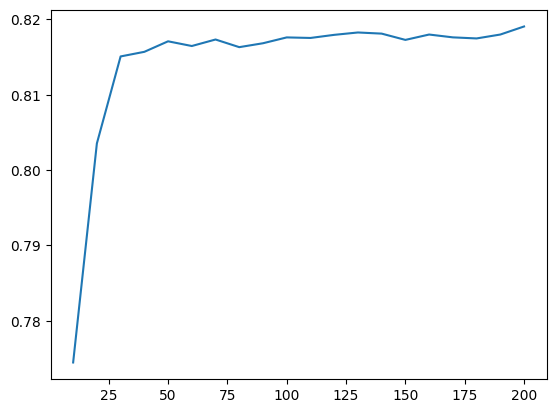

In [90]:
# x-axis: # of trees
# y-axis: AUC
plt.plot(df_scores.n_estimators, df_scores.auc)

The performance grows rapidly for the first 25-30 trees; then the growth slows down. After 50 trees, adding more trees is not helpful anymore: the performance stays approximately at the level of 81.5%. We see that at some point, it doesn't make sense to train more trees. It's enough to just have 50. Let's just say it's fine to have 50 experts, but having 51, 52 and so on experts do not contribute that much to the performance. 

The number of trees is not the only parameter we can change to get better performance. 

A random forest ensemble consists of multiple decision trees, so the most important parameters we need to tune for random forest are the same:
- `max_depth`
- `min_leaf_size`

We can change other parameters, but we won't cover them in detail here. Refer to the official documentation for more information: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

Let's start with `max_depth`. We already know that this parameter significantly affects the performance of a decision tree. This is also the case for random forest: larger trees tend to overfit more than smaller trees. 

We'll test a few values for `max_depth` and see how AUC evolves as the number of trees grow. 

In [91]:
# Train a random forest model for different depth parameters
scores = []

# Iterates over different depth values
for d in [5, 10, 15]:
    # Iterates over different n_estimator values
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        # Evaluates the model
        auc = roc_auc_score(y_val, y_pred)

        scores.append((d, n, auc))

In [92]:
columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.sort_values(by='auc', ascending=False).head()

,max_depth,n_estimators,auc
35,10,160,0.825243
39,10,200,0.824923
37,10,180,0.824801
36,10,170,0.824632
38,10,190,0.824535


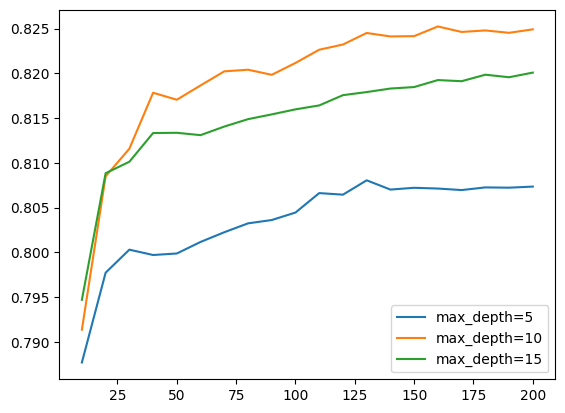

In [93]:
# Plot number of estimators on the x-axis and auc on the y-axis for each level of depth
for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             label='max_depth=%d' % d)

plt.legend()

We see that 10 is the best one. With `max_depth = 10`, AUC goes over 82%, whereas for other values, it performs worse. 

Now, let's tune `min_samples_leaf`. We set the value for the `max_depth` parameter from the previous step and then follow the same approach as previously for determining the best value for `min_samples_leaf`. 

In [94]:
max_depth = 10

In [95]:
scores = []

for s in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((s, n, auc))

In [96]:
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.sort_values(by='auc', ascending=False).head()

,min_samples_leaf,n_estimators,auc
58,5,190,0.825952
35,3,160,0.825655
59,5,200,0.825383
52,5,130,0.825286
37,3,180,0.825268


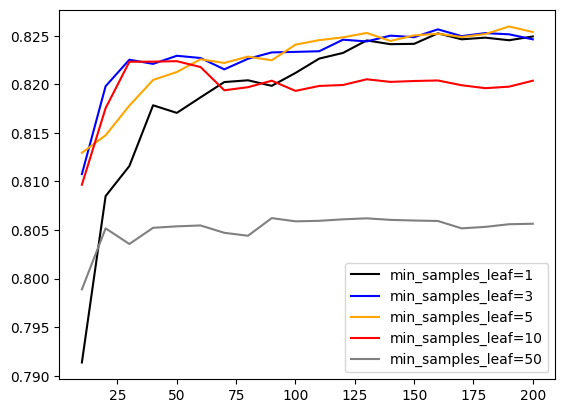

In [97]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
values = [1, 3, 5, 10, 50]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             color=col,
             label='min_samples_leaf=%d' % s)

plt.legend()

We can clearly see that 3 and 5 are the best performing ones, though not really clear which one to keep here. 

We would probably go with the blue (3) one because it starts getting good performance earlier than others. Looking at the performance of the model in the range within 150 to 175 trees, going with the blue makes more sense. 

So, let's go with `min_samples_leaf` of 3 as our best value. We achieve the best AUC with about 160 trees, so we should set the `n_estimators` parameter to 160. We'll retrain our final random forest model with these values (`max_depth`: 10, `min_samples_leaf`: 3, and `n_estimators`: 160).

In [98]:
min_samples_leaf = 3

In [99]:
rf = RandomForestClassifier(n_estimators=160,
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf,
                            random_state=1,
                            n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=160,
                       n_jobs=-1, random_state=1)

> **NOTE:** These two parameters are not the only parameters that we can tune, there are a lot more parameters we can use to tune our random forest model. 

Other useful parameters:

* `max_features`: specifies the number of features to consider when looking for the best split. 
* `bootstrap`: specifies whether bootstrap samples are used when building trees (another approach to randomization but on the row level). If False, the whole dataset is used to build each tree.
  * because we want our decision trees to be different from each other as much as possible, bootstrap is another way of making them different from each other.
* `n_jobs`: specifies the number of jobs to run in parallel. `fit`, `predict`, `decision_path`, and `apply` are all parallelized over the trees. Essentially, it is a parameter that helps speed up the process of training a lot of models. 
  * `None` means 1 (default).
  * `-1` means using all available processors.
  * Open `htop` (linux command) to show how many processors are running.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

> **IMPORTANT:** To make an ensemble useful, trees in a random forest should be different from each other. This is done by randomly selecting a different subset of features for each tree. 

Random forest is not the only way to combine multiple decision trees. There's a different approach: gradient boosting. 

## 6.7 Gradient boosting and XGBoost
* Gradient boosting vs random forest
* Installing XGBoost
* Training the first model
* Performance monitoring
* Parsing xgboost's monitoring output

In a random forest, each tree is independent: it's trained on a different set of features. After individual trees are trained, we combine all their decisions together to get the final decision. 

It's not the only way to combine multiple models together in one ensemble, however. Alternatively, we can train models sequentially--each next model tries to fix errors from the previous one:
- Train the first model.
- Look at the errors it makes.
- Train another model that fixes these errors.
- Look at the errors again; repeat sequentially.

This way of combining models is called *boosting*. *Gradient boosting* is a particular variation of this approach that works especially well with trees. 

**Gradient Boosting**

Unlike Random Forest where each decision tree trains independently, in the Gradient Boosting Trees, the models are combined sequentially, where each model takes the prediction errors made by the previous model and then tries to improve the prediction. This process continues to `n` number of iterations, and in the end, all the predictions get combined to make the final prediction. 

> **Gradient Boosting Trees**
> 
> DATA (*Input*) $\rightarrow$ MODEL1 $\rightarrow$ PRED1 $\rightarrow$ ERRORS OF MODEL1 $\rightarrow$ MODEL2 $\rightarrow$ PRED2 $\rightarrow$ ERRORS OF MODEL2 $\rightarrow$ MODEL3 $\rightarrow$ PRED3 $\rightarrow$ ERRORS OF MODEL3 $\rightarrow$ MODEL4 $\rightarrow$ PRED4 $\rightarrow$ FINAL PREDICTION (*Output*)

XGBoost is one of the libraries which implements the gradient boosting technique. To make use of the library, we need to install with `pip install xgboost`. To train and evaluate the model, we need to wrap our train and validation data into a special data structure from XGBoost, which is called `DMatrix`. This data structure is optimized to train XGBoost models faster. 

**XGBoost Training Parameters**
- `eta`: learning rate, which indicates how fast the model learns.
- `max_depth`: to control the size of the trees.
- `min_child_weight`: to control the minimum size of a child node.
- `objective`: To specify which problem we are trying to solve; either regression or classification (binary: `'binary:logistic'`, or others).
- `nthread`: 8, used for parallelized training.
- `seed`: 1, for reproducibility.
- `verbosity`: 1 (`True`) to show warnings, if any, during model training.

**Classes, functions, and methods:**
- `xgb.train()`: method to train xgboost model.
- `xgb_params`: key-value pairs of hyperparameters to train xgboost model.
- `watchlist`: list to store training and validation data to evaluate the performance of the model after each training iteration. The list takes tuple of train and validation set from DMatrix wrapper, for example, `watchlist = [(dtrain, 'train'), (dval, 'val')]`.
- `%%capture output`: IPython magic command which captures the standard output and standard error of a cell.

#### Extracting results from `xgb.train(...)`
In the video, we use jupyter magic command `%%capture output` to extract the output of `xgb.train(...)` method. 

Alternatively, you can use the `evals_result` parameter of the `xgb.train(...)`. You can pass an empty dictionary in for this parameter and the train() method will populate it with the results. The result will be of type `OrderedDict` so we have to transform it into a DataFrame. For this, `zip()` can help. Here's an example code snippet:

```python
evals_result = {}

model = xgb.train(params=xgb_params,
                  dtrain=dm_train,
                  num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist,
                  evals_result=evals_result)

columns = ['iter', 'train_auc', 'val_auc']
train_aucs = list(evals_result['train'].values())[0]
val_aucs = list(evals_result['val'].values())[0]

df_scores = pd.DataFrame(
    list(zip(
        range(1, len(train_aucs) + 1),
        train_aucs,
        val_aucs
    )), columns=columns)

plt.plot(df_scores.iter, df_scores.train_auc, label='train')
plt.plot(df_scpres.iter, df_scores.val_auc, label='val')
plt.legend()
```

Let's have a look at how we can use Gradient boosting for solving our problem.

We have many good implementations of the gradient boosting model: `GradientBoostingClassifier` from Scikit-learn, XGBoost, LightGBM, and CatBoost. In this chapter, we use XGBoost (short for "Extreme Gradient Boosting"), which is the most popular implementation.

XGBoost doesn't come with Anaconda, so to use it, we need to install it. The easiest way is to install it with `pip`:

In [100]:
!pip install xgboost

In [101]:
import xgboost as xgb

> **NOTE:** In some cases, importing XGBoost may give you a warning like `YMLLoadWarning`. You shouldn't worry about it; the library will work without problems. 

Using the alias `xgb` when importing XGBoost is a convention, just like with other popular machine learning packages in Python. 

Before we can train an XGBoost model, we need to wrap our data into `DMatrix`--a special data structure for finding splits efficiently so that XGBoost can train faster. 

In [102]:
# Wrap our training data into a special data structure internal to XGBoost
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [103]:
dtrain

The next step is specifying the parameters for training. We're using only a small subset of the default parameters of XGBoost:
- `eta`: specifies the learning rate (how fast our model learns). The default value is 0.3.
- `max_depth`: controls the size of the trees (similar to `max_depth` in Random Forest). The default value is 6. 
- `min_child_weight`: specifies how many observations we should have in a leaf node (similar to `min_samples_leaf` in Random Forest). The default value is 1.
- `objective`: specifies the learning task and the corresponding learning objective. We need a binary logistic model (similar to logistic regression) for our binary classification problem.
- `nthread`: specifies how many threads we use. Set it to the number of cores you have in your machine.
- `seed`: set the seed to fix the randomization involved for reproducibility.
- `verbosity`: controls what kind of warnings we have when we train our model or do we want to see warnings when training. Valid values of 0 (silent), 1 (warning), 2 (info), and 3 (debug). 

Refer to this page for more details on all the parameters that XGBoost has: https://xgboost.readthedocs.io/en/stable/parameter.html


For us, the most important parameter now is `objective`: it specifies the learning task. 

We're solving a binary classification problem--that's why we need to choose `binary:logistic`. 

For training an XGBoost model, we use the `train` function. 

We provide three arguments to `train`:
- `xgb_params`: the parameters for training
- `dtrain`: the dataset for training (an instance of `DMatrix`)
- `num_boost_round=10`: the number of trees to train


In [104]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

# num_boost_round: specifies how many trees we want to grow
model = xgb.train(xgb_params, dtrain, num_boost_round=200)

In [105]:
model

To evaluate the model, we need to make a prediction on the validation dataset. For that, use the `predict` method with the validation data wrapped in `DMatrix`.

In [106]:
y_pred = model.predict(dval)
y_pred[:10]

array([3.4326155e-02, 6.9084560e-04, 3.0369125e-03, 9.8177880e-02,
       8.9028952e-05, 1.0331396e-03, 1.3568992e-03, 2.6982179e-01,
       3.8441682e-01, 8.6307751e-05], dtype=float32)

The result, `y_pred`, is a one-dimensional NumPy array with predictions: the risk score for each customer in the validation dataset. 

Next, we calculate AUC using the same approach as previously:

In [107]:
roc_auc_score(y_val, y_pred)

np.float64(0.8072491584122448)

We see that our AUC is about 81%, which is quite good considering that we didn't do anything else. We only put the default parameters here and that's it. So for default parameters, this is quite good. 

Let's see what happens if we just train 10 trees. 

In [108]:
# num_boost_round: specifies how many trees we want to grow
model = xgb.train(xgb_params, dtrain, num_boost_round=10)
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

np.float64(0.8065256351262986)

The performance is about the same, though it performed slightly worse than the model trained with 200 trees. 

XGboost model is quite prone to overfitting that's why we need to be careful about how many trees we train and the size of these trees. We don't want these trees to be too big. 

Also, training an XGBoost model is simpler when we can see how its performance changes when the number of trees grows. 

#### Model performance monitoring
To get an idea of how AUC changes as the number of trees grows, we can use a watchlist--a built-in feature in XGBoost for monitoring model performance. 

A watchlist is a Python list with tuples. Each tuple contains a `DMatrix` and its name. This is how we typically do it:

In [109]:
# watchlist = [(train DMatrix, 'name_of_this_dataset'), (val DMatrix, 'name_of_this_dataset')]
watchlist = [(dtrain, 'train'), (dval, 'val')]

Additionally, we need to modify the list of parameters for training to specify the metric we use for evaluation. In our case, it's the AUC.

To use the watchlist during training, we need to specify two extra arguments for the `train` function:
- `evals`: the watchlist.
- `verbose_eval`: how often we print the metric. If we set it to "10", we see the result after each 10th step. 

In [110]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [111]:
s = output.stdout

In [112]:
print(s)

[0]	train-auc:0.86730	val-auc:0.77938
[5]	train-auc:0.93086	val-auc:0.80858
[10]	train-auc:0.95447	val-auc:0.80851
[15]	train-auc:0.96554	val-auc:0.81334
[20]	train-auc:0.97464	val-auc:0.81729
[25]	train-auc:0.97953	val-auc:0.81686
[30]	train-auc:0.98579	val-auc:0.81543
[35]	train-auc:0.99011	val-auc:0.81206
[40]	train-auc:0.99421	val-auc:0.80922
[45]	train-auc:0.99548	val-auc:0.80842
[50]	train-auc:0.99653	val-auc:0.80918
[55]	train-auc:0.99765	val-auc:0.81114
[60]	train-auc:0.99817	val-auc:0.81172
[65]	train-auc:0.99887	val-auc:0.80798
[70]	train-auc:0.99934	val-auc:0.80870
[75]	train-auc:0.99965	val-auc:0.80555
[80]	train-auc:0.99979	val-auc:0.80549
[85]	train-auc:0.99988	val-auc:0.80374
[90]	train-auc:0.99993	val-auc:0.80409
[95]	train-auc:0.99996	val-auc:0.80548
[100]	train-auc:0.99998	val-auc:0.80509
[105]	train-auc:0.99999	val-auc:0.80629
[110]	train-auc:1.00000	val-auc:0.80637
[115]	train-auc:1.00000	val-auc:0.80494
[120]	train-auc:1.00000	val-auc:0.80574
[125]	train-auc:1.0000

In [113]:
print(s[:200])

[0]	train-auc:0.86730	val-auc:0.77938
[5]	train-auc:0.93086	val-auc:0.80858
[10]	train-auc:0.95447	val-auc:0.80851
[15]	train-auc:0.96554	val-auc:0.81334
[20]	train-auc:0.97464	val-auc:0.81729
[25]	tr


In [114]:
line = s.split('\n')[0]
line

'[0]\ttrain-auc:0.86730\tval-auc:0.77938'

In [115]:
line.split('\t')

['[0]', 'train-auc:0.86730', 'val-auc:0.77938']

In [116]:
num_iter, train_auc, val_auc = line.split('\t')
num_iter

'[0]'

In [117]:
# Remove the brackets and convert it to an integer
int(num_iter.strip('[]'))

0

In [118]:
train_auc.split(':')

['train-auc', '0.86730']

In [119]:
# Retrieve the AUC and convert it to a float
float(train_auc.split(':')[1])

0.8673

In [120]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [121]:
df_score = parse_xgb_output(output)
df_score[:5]

,num_iter,train_auc,val_auc
0,0,0.86730,0.77938
1,5,0.93086,0.80858
2,10,0.95447,0.80851
3,15,0.96554,0.81334
4,20,0.97464,0.81729


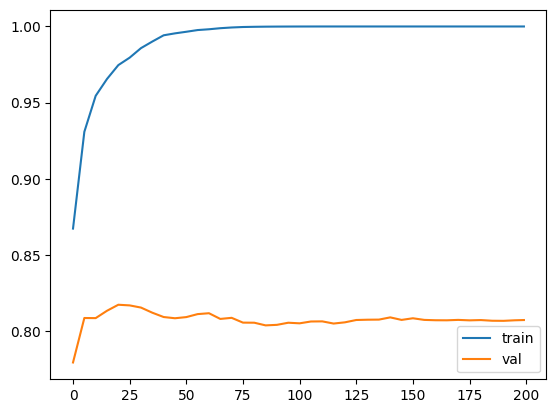

In [122]:
# Plot the effect of the number of trees on the AUC from train and validation sets
plt.plot(df_score.num_iter, df_score.train_auc, label='train')
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

We see that the train score is always growing. This behavior is expected: in boosting, every next model tries to fix the mistakes from the previous step, so the score is always improving. 

But for the validation score, this is not the case. It goes up initially but then starts to decline and stagnate. This is the effect of overfitting: our model becomes more and more complex until it simply memorizes the entire training set. It's not helpful for predicting the outcome for the customers outside of the training set, and the validation score reflects that. 

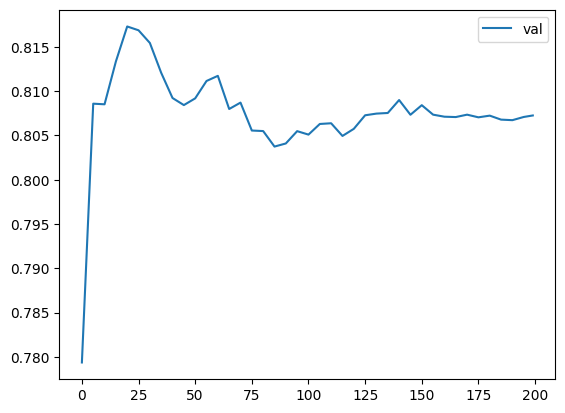

In [123]:
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

In [124]:
df_score.sort_values(by='val_auc', ascending=False)[:5]

,num_iter,train_auc,val_auc
4,20,0.97464,0.81729
5,25,0.97953,0.81686
6,30,0.98579,0.81543
3,15,0.96554,0.81334
7,35,0.99011,0.81206


We get the best AUC on the 20th iteration (81.7%).

Next, we'll see how to get the best out of XGBoost by tuning its parameters. 

## 6.8 XGBoost parameter tuning
XGboost has various tunable parameters but the three most important ones are:
* `eta` (default=0.3)
  * It is also called `learning_rate` and is used to prevent overfitting by regularizing the weights of new features in each boosting step (range: [0, 1]).
  * Decision trees and Random forest don't have this parameter. 
* `max_depth` (default=6)
  * The maximum allowed depth of each tree. Increasing this value will make the model more complex and more likely to overfit (range: [0, inf]).
  * Same as `max_depth` in `DecisionTreeClassifier` from Scikit-learn.
* `min_child_weight` (default=1)
  * The minimal number of observations in each group/leaf node (range: [0, inf]).
  * Same as `min_leaf_size` in `DecisionTreeClassifier` or `min_samples_leaf` in `RandomForestClassifier` from Scikit-learn. 

> **Note:** The above three parameters control the training process.

For XGBoost models, there are other ways of finding the best parameters as well, but the one we implemented in this notebook follows the sequence of:
- First, find the best value for `eta`
- Second, find the best value for `max_depth`
- Third, find the best value for `min_child_weight`

Other useful parameters are:
- `subsample` (default=1)
  - Subsample ratio of the training instances. Setting it to 0.5 means that model would randomly sample half of the training data prior to growing trees (range: (0, 1]).
- `colsample_bytree` (default=1)
  - This is similar to random forest, where each tree is trained with the subset of randomly chosen features.
- `lambda` (default=1)
  - Also called `reg_lambda`. L2 regularization term on weights. Increasing this value will make model more conservative.
- `alpha` (default=0)
  - Also called `reg_alpha`. L1 regularization term on weights. Increasing this value will make model more conservative.

This is not the full list of parameters. Refer to the official documentation to learn more about all the parameters: https://xgboost.readthedocs.io/en/latest/parameter.html


Previously, we used a subset of default parameters for training our XGBoost. Here, we'll learn to tune its parameters. 

We're mostly interested in the first three parameters: `eta`, `max_depth`, and `min_child_weight`. 

We already know `max_depth` and `min_child_weight` (same as `min_leaf_size` or `min_samples_leaf`), but we haven't come across `eta`--the learning rate parameter. Let's look into it and see how we can optimize it. 

#### Learning Rate
In boosting, each tree tries to correct the mistakes from the previous iterations. Learning rate determines the weight of this correction. If we have a large value for `eta`, the correction overweights the previous predictions significantly. On the other hand, if the value is small, only a small fraction of this correction is used. 

$$ETA = \text{Learning Rate} = \text{size of step}$$

In practice, it means:
- If `eta` is too large, the model starts to overfit quite early without realizing its full potential.
- If it's too small, we need to train too many trees before it can produce good results.

The default value of 0.3 is reasonably good for large datasets, but for smaller datasets like ours, we should try smaller values like 0.1 or even 0.05. 

**We'll tune the following parameters in order:**
1. `eta`
2. `max_depth`
3. `min_child_weight`

Let's start by trying a range of values for `eta`. 1.0 is the maximum value we can have for `eta`. 

Now that we can use a watchlist to monitor the performance of our model, we can train for as many iterations as we want. Let's go with 200 rounds for training. 

In [125]:
scores = {}

In [126]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [127]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.3'

In [128]:
scores['eta=0.3'][:5]

,num_iter,train_auc,val_auc
0,0,0.86730,0.77938
1,5,0.93086,0.80858
2,10,0.95447,0.80851
3,15,0.96554,0.81334
4,20,0.97464,0.81729


In [129]:
%%capture output

xgb_params = {
    'eta': 1.0, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [130]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=1.0'

In [131]:
scores['eta=1.0'][:5]

,num_iter,train_auc,val_auc
0,0,0.86730,0.77938
1,5,0.95857,0.79136
2,10,0.98061,0.78355
3,15,0.99549,0.78050
4,20,0.99894,0.78591


In [132]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [133]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.1'

In [134]:
scores['eta=0.1'][:5]

,num_iter,train_auc,val_auc
0,0,0.86730,0.77938
1,5,0.90325,0.79290
2,10,0.91874,0.80510
3,15,0.93126,0.81380
4,20,0.93873,0.81804


In [135]:
%%capture output

xgb_params = {
    'eta': 0.05, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [136]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.05'

In [137]:
scores['eta=0.05'][:5]

,num_iter,train_auc,val_auc
0,0,0.86730,0.77938
1,5,0.88650,0.79584
2,10,0.90368,0.79623
3,15,0.91072,0.79938
4,20,0.91774,0.80510


In [138]:
%%capture output

xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [139]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.01'

In [140]:
scores['eta=0.01'][:5]

,num_iter,train_auc,val_auc
0,0,0.86730,0.77938
1,5,0.87157,0.77925
2,10,0.87247,0.78051
3,15,0.87541,0.78302
4,20,0.87584,0.78707


In [141]:
scores.keys()

dict_keys(['eta=0.3', 'eta=1.0', 'eta=0.1', 'eta=0.05', 'eta=0.01'])

We have all these evaluation results in the dataframes. Now, let's plot them on a graph to show the effect of the `eta` parameter on the validation score. 

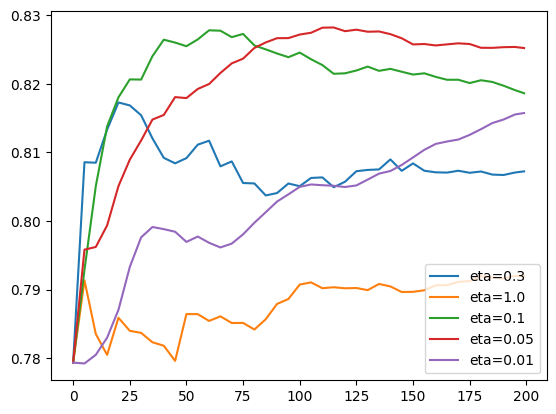

In [142]:
for eta, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=eta)

plt.legend()

For ease of comparison, let's just plot three different values of `eta` on the graph each time.

We'll start with `eta=1.0`, `eta=0.3`, and `eta=0.1`. 

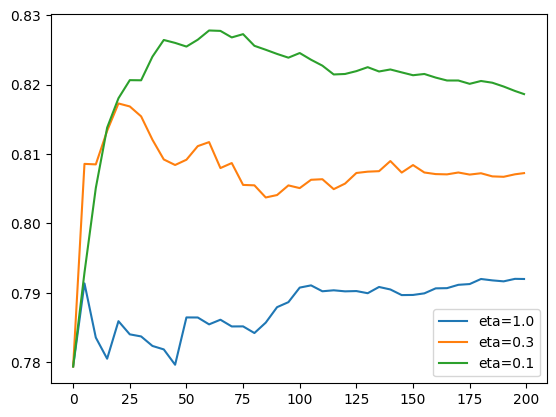

In [143]:
etas = ['eta=1.0', 'eta=0.3', 'eta=0.1']

for eta in etas:
    df_score = scores[eta]
    plt.plot(df_score.num_iter, df_score.val_auc, label=eta)

plt.legend()

We see that `eta` of 1.0 performs the worst. 

`eta` of 0.3 learns quite fast but then at some point, starts to degrade because the steps are too large so it starts overfitting. 

`eta` of 1.0 needs more iterations to become better. Although it learns slower, it was able to learn better. And then when it starts degrading, it also doesn't overfit as fast as `eta` of 0.3. 

Let's plot `eta=0.3`, `eta=0.1`, and `eta=0.01` on a graph to compare their performance.

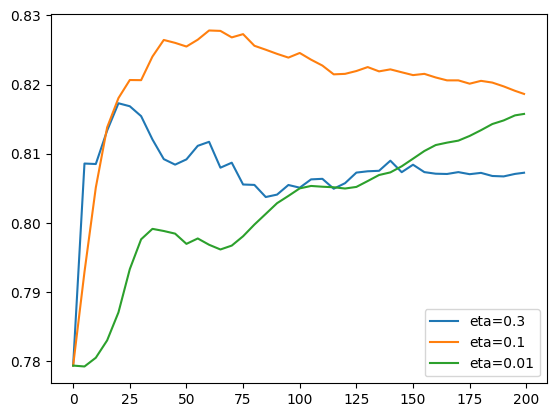

In [144]:
etas = ['eta=0.3', 'eta=0.1', 'eta=0.01']

for eta in etas:
    df_score = scores[eta]
    plt.plot(df_score.num_iter, df_score.val_auc, label=eta)

plt.legend()

We see that `eta` of 0.01 learns very slowly and we've no idea how much time it needs to be eventually better than `eta` of 0.1. It simply needs too many iterations so it takes forever to learn. The steps it takes are tiny that's why it takes forever for this model to learn while `eta` of 0.3 takes quite a few big steps before it starts overfitting quickly. If we tried it for more iterations, it could potentially get to the same level of AUC as other values. However, it's not practical: it becomes computationally expensive to evaluate all these trees during prediction time. 

`eta` of 0.1 seems to be in the sweet spot. It needs quite a few iterations but the performance is also better. 

Let's plot `eta=0.1`, `eta=0.05`, and `eta=0.01` on a graph to compare their performance.

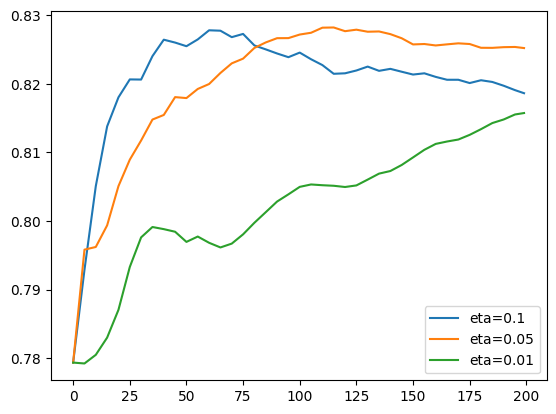

In [145]:
etas = ['eta=0.1', 'eta=0.05', 'eta=0.01']

for eta in etas:
    df_score = scores[eta]
    plt.plot(df_score.num_iter, df_score.val_auc, label=eta)

plt.legend()

`eta` of 0.05 takes approximately two times more to reach its peak. `eta` of 0.1 reaches its peak at about 60 iterations while `eta` of 0.05 takes about 110 iterations. 

It seems like `eta` of 0.1 is the best amongst the values. It doesn't need a lot of trees and it has the best performance.

> **IMPORTANT:** We have a gradient boosting model with `eta=0.1`. It needs 60 trees to get its peak performance. If we increase `eta` to 0.5, the model will need fewer trees to reach its peak performance. 

The next parameter we tune is `max_depth`. The default value is 6, so we can try:
- A lower value; for example: 3
- A higher value; for example: 10

The outcome should give us an idea if the best value for `max_depth` is between 3 and 6 or between 6 and 10. 

In [146]:
scores = {}

We use `max_depth=6` as the baseline for comparing different max depth values. 

In [147]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [148]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

'max_depth=6'

In [149]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [150]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

'max_depth=3'

In [151]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 4,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [152]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

'max_depth=4'

In [153]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 10,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [154]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

'max_depth=10'

In [155]:
scores.keys()

dict_keys(['max_depth=6', 'max_depth=3', 'max_depth=4', 'max_depth=10'])

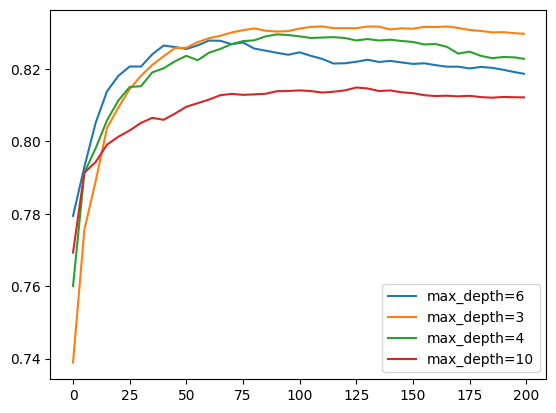

In [156]:
for max_depth, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=max_depth)

plt.legend()

We see that the optimal value for `max_depth` is 3.

Let's delete `max_depth=10` to zoom in a little on other max depth values. 

In [157]:
del scores['max_depth=10']

We want to limit the y in this range (within 0.8 to 0.84). 

For that, we will use `plt.ylim(0.8, 0.84)`.

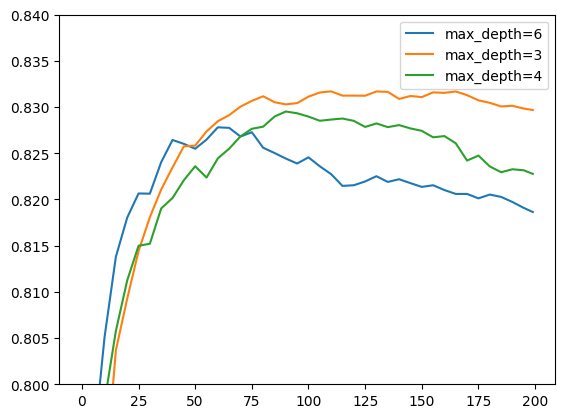

In [158]:
for max_depth, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=max_depth)

plt.ylim(0.8, 0.84)
plt.legend()

Now, this is easier to see what's going on. The `max_depth` of 6 is actually worse than the others after 40 trees. It also declines the fastest. 

We conclude that the `max_depth` of 3 is the best depth.

The next parameter we tune is `min_child_weight`. It's the same as `min_leaf_size` in decision trees from Scikit-learn. It controls the minimal number of observations a tree can have in a leaf. 

Let's try a range of values and see which one works best. In addition to the default value (1), we can try 10 and 30. 

In [159]:
scores = {}

In [160]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [161]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)
key

'min_child_weight=1'

In [162]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 10,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [163]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)
key

'min_child_weight=10'

In [164]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 30,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [165]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)
key

'min_child_weight=30'

In [166]:
scores.keys()

dict_keys(['min_child_weight=1', 'min_child_weight=10', 'min_child_weight=30'])

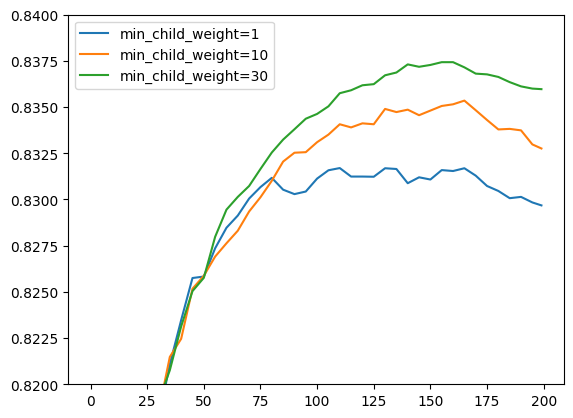

In [167]:
for min_child_weight, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=min_child_weight)

plt.ylim(0.82, 0.84)
plt.legend()

We see that `min_child_weight` of 30 is always better than the rest so we'll go with 30 as our optimal value. 

Before we can finish the model, we need to do one last step: select the optimal number of trees. It's quite simple: look at the iteration when the validation score peaked and use this number. 

In our case, we need to train 155 trees for our final model. 

In [176]:
scores['min_child_weight=30'].sort_values(by='val_auc', ascending=False)[:5]

,num_iter,train_auc,val_auc
32,160,0.89970,0.83743
31,155,0.89918,0.83743
28,140,0.89760,0.83731
30,150,0.89866,0.83728
29,145,0.89821,0.83718


We can usually skip these plots when training models by looking at the raw output. And sometimes, prepare a pen and paper to write it down (or use excel spreadsheet) when experimenting. 

Try and see what works best for you. Plotting works quite well to give some initial intuition but you can see if we really need to have these plots to capture the outputs because it involved a fair bit of overhead that may not be worth it. 

In [177]:
# Parameters for our final model
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 30,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=155)

The best AUC achieved on validation for our Random forest model was 82.6%, whereas the best AUC achieved on validation for our Gradient boosting model was 1.1% more (83.7%). 

We conclude that Gradient boosting is the best model, so let's use it as our final model for scoring loan applications. 

Other parameters: https://xgboost.readthedocs.io/en/latest/parameter.html

Useful ones:

* `subsample` and `colsample_bytree`
* `lambda` and `alpha`

`colsample_bytree`: 
- Similar to what we saw in Random forest, where every decision tree can get a subset of columns/features.
- This parameter controls how many features in each tree at each iteration during training (default: 1.0).
- Usually, we try experimenting it with 0.3 and 0.6 to see which one works best. If let's say 0.6 works best, then try some values around that. Slowly, we see which one is better. 

`subsample`: 
- Similar to `colsample_bytree` but instead of sampling columns/features, we're sampling rows.
- For example, if we set this parameter to 0.5, then at each iteration, instead of getting all the training data, we get only 50% of the data. And these data are randomly selected.
- Usually, we try experimenting it with 0.3, 0.5, and 0.7 to get some idea on which value makes more sense for this parameter or whether we should change the value to try some other values. 

This concludes the lesson for parameter tuning. 

The order in which we tuned these parameters would works well but it's not the only way of tuning parameters. We can tune them in other sequence because there are many rules of thumbs. Look it up on the internet by searching "tuning xgboost hyperparameters" on Google and you will find a lot of resources. 

There are many tutorials with different ways of tuning XGBoost parameters. The best learning resource to learn more on this is from Kaggle, "A Guide on XGBoost hyperparameters tuning": https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning

## 6.9 Selecting the final model

* Choosing between xgboost, random forest and decision tree
* Training the final model
* Saving the model

In [ ]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

In [ ]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

In [ ]:
rf = RandomForestClassifier(n_estimators=200,
                            max_depth=10,
                            min_samples_leaf=3,
                            random_state=1)
rf.fit(X_train, y_train)

In [ ]:
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

In [ ]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=175)

In [ ]:
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

In [ ]:
df_full_train = df_full_train.reset_index(drop=True)

In [ ]:
y_full_train = (df_full_train.status == 'default').astype(int).values

In [ ]:
del df_full_train['status']

In [ ]:
dicts_full_train = df_full_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)

dicts_test = df_test.to_dict(orient='records')
X_test = dv.transform(dicts_test)

In [ ]:
dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train,
                    feature_names=dv.get_feature_names_out())

dtest = xgb.DMatrix(X_test, feature_names=dv.get_feature_names_out())

In [ ]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dfulltrain, num_boost_round=175)

In [ ]:
y_pred = model.predict(dtest)

In [ ]:
roc_auc_score(y_test, y_pred)

## 6.10 Summary

* Decision trees learn if-then-else rules from data.
* Finding the best split: select the least impure split. This algorithm can overfit, that's why we control it by limiting the max depth and the size of the group.
* Random forest is a way of combininig multiple decision trees. It should have a diverse set of models to make good predictions.
* Gradient boosting trains model sequentially: each model tries to fix errors of the previous model. XGBoost is an implementation of gradient boosting. 

## 6.11 Explore more

* For this dataset we didn't do EDA or feature engineering. You can do it to get more insights into the problem.
* For random forest, there are more parameters that we can tune. Check `max_features` and `bootstrap`.
* There's a variation of random forest caled "extremely randomized trees", or "extra trees". Instead of selecting the best split among all possible thresholds, it selects a few thresholds randomly and picks the best one among them. Because of that extra trees never overfit. In Scikit-Learn, they are implemented in `ExtraTreesClassifier`. Try it for this project.
* XGBoost can deal with NAs - we don't have to do `fillna` for it. Check if not filling NA's help improve performance.
* Experiment with other XGBoost parameters: `subsample` and `colsample_bytree`.
* When selecting the best split, decision trees find the most useful features. This information can be used for understanding which features are more important than otheres. See example here for [random forest](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html) (it's the same for plain decision trees) and for [xgboost](https://stackoverflow.com/questions/37627923/how-to-get-feature-importance-in-xgboost)
* Trees can also be used for solving the regression problems: check `DecisionTreeRegressor`, `RandomForestRegressor` and the `objective=reg:squarederror` parameter for XGBoost.